# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.colors as colors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

torch device: cuda


In [3]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [4]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [5]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

In [6]:
def poly_bead_rmsd(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0)
    rmsd = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        tdiff_mat = (tcom_arr[:,:,i:] - pol_com[:,i:]) - (tcom_arr[:,:,:-i] - pol_com[:,:-i])
        rmsd[i] = torch.einsum('ijk,ijk->', tdiff_mat, tdiff_mat)/((Ttot-i)*n)
        
    return rmsd


In [7]:
def poly_autocorr(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0).to(device)
    autocorr = torch.zeros(Ttot, device=device)
    autocorr[0] = torch.einsum('ijk,ijk->ik', 
                                (tcom_arr[:,:,:] - pol_com[:,:]), 
                            (tcom_arr[:,:,:] - pol_com[:,:])).mean()
    for i in tqdm(list(range(1,Ttot))):
        autocorr[i] = torch.einsum('ijk,ijk->ik', 
                                    (tcom_arr[:,:,i:] - pol_com[:,i:]), 
                                (tcom_arr[:,:,:-i] - pol_com[:,:-i])).mean()
        
    return autocorr


In [8]:
        
def poly_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_arr-pol_com, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)


In [15]:
def power_spec(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(axis=0).to(device)
    nsteps = tcom_arr.shape[-1]
    # n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_arr-pol_com, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))[:,:nsteps].real
    return power_spec.mean(dim=0)
        


In [10]:
def sep_autocorr(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    n = tsep_mat.shape[0]
    Ttot = tsep_mat.shape[-1]
    tcorr_d = torch.zeros(tsep_mat.shape[-1], device=device)
    avg_tsep_mat = tsep_mat.mean(dim=(0,1)).to(device)
    avg_sep = avg_tsep_mat.mean()
    for i in range(1,tsep_mat.shape[-1]):
        tcorr_d[i] = ((tsep_mat[:,:,i:] - avg_tsep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_tsep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))
    # del avg_tsep_mat
    # del tsep_mat
    # del tcom_arr
        
    return tcorr_d


In [11]:
def autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    t0 = time.time()
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    t1 = time.time()
    print(f'tsep_mat = {t1-t0}')
    nsteps = tsep_mat.shape[-1]
    n = next_pow_two(nsteps)
    t2 = time.time()
    print(f'power of two = {t2-t1}')

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tsep_mat, s=[2 * n], dim=[-1])
    t3 = time.time()
    print(f'fft = {t3-t2}')
    autocorr = torch.fft.ifftn(torch.einsum('ijk,ijk->ik', f,
                                       torch.conjugate(f)),
                             dim=[-1])[:,:nsteps].real
    t4 = time.time()
    print(f'ifft = {t4-t3}')

    autocorr /= 4 * n
    return autocorr


In [12]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

# Data generation

## Rheology calculations

0it [00:00, ?it/s]

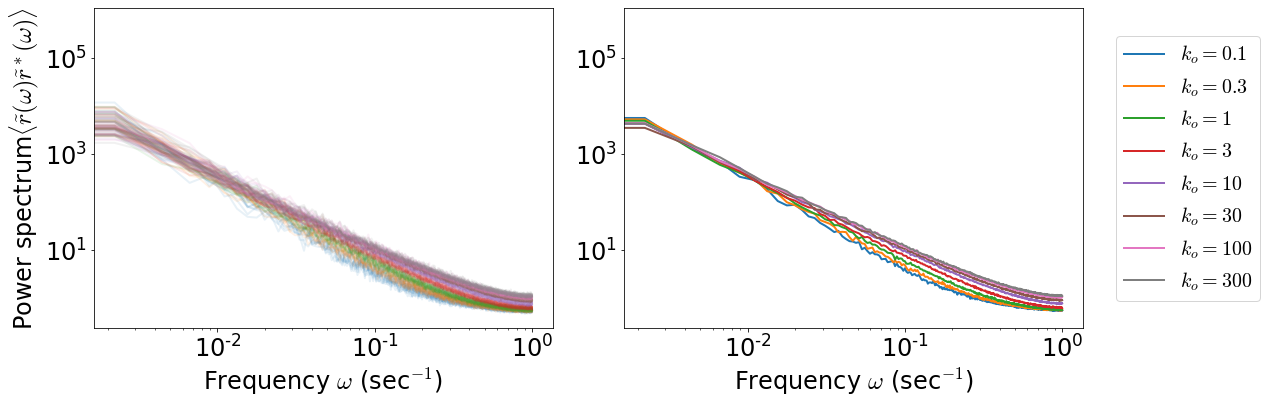

In [67]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_power_spec_list = []
    std_auto_corr_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in power_spec_list])
        power_spec_mat = torch.stack([avg[:min_length] for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(axis=0)]
        std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_power_spec_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Power spectrum' + r'$\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle$')
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

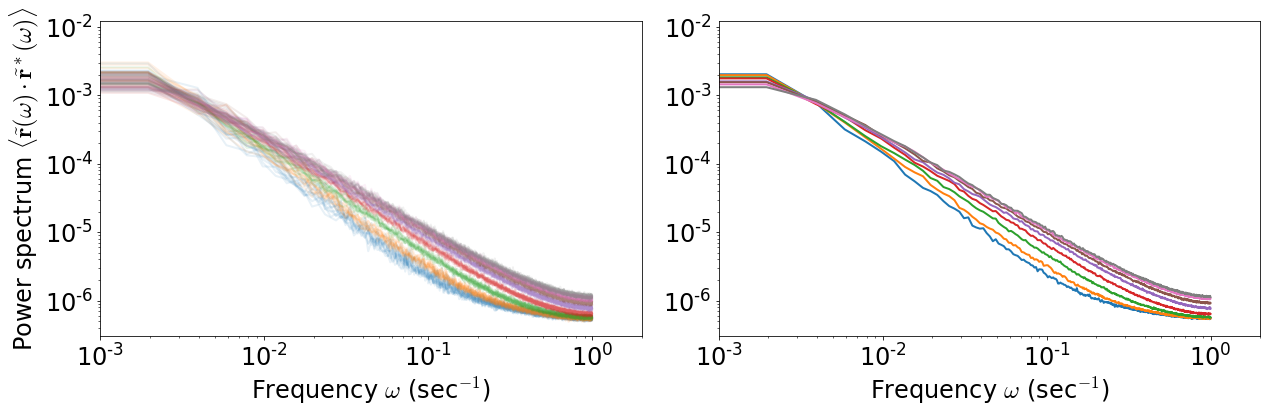

In [66]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_power_spec_list = []
    std_auto_corr_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            # i_valid = int((ss_ind+end_ind)/2)
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n = com_arr.shape[-1]
            n_valid = int(n/2)
            time_arr = h5_data['time'][:n_valid]
            
            ps = power_spec(com_arr)
            power_spec_list += [ps[:n_valid]]
            freq = torch.fft.fftfreq(n_valid*2, time_arr[2]-time_arr[1])
            n_freq = int(freq.size(0)/2)
            _ = axarr1[0].plot(freq[:n_freq], ps[:n_freq].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in power_spec_list])
        power_spec_mat = torch.stack([avg[:min_length] for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(axis=0)]
        std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(min_length*2, time_arr[2]-time_arr[1])
        n_freq = int(freq.size(0)/2)
        _ = axarr1[1].plot(freq[:n_freq], avg_power_spec_list[-1][:n_freq].to('cpu'), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Power spectrum ' + r'$\langle \tilde{{\bf r}}(\omega)\cdot\tilde{{\bf r}}^*(\omega)\rangle$')
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_xlim(.001,2)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

True


IndexError: list index out of range

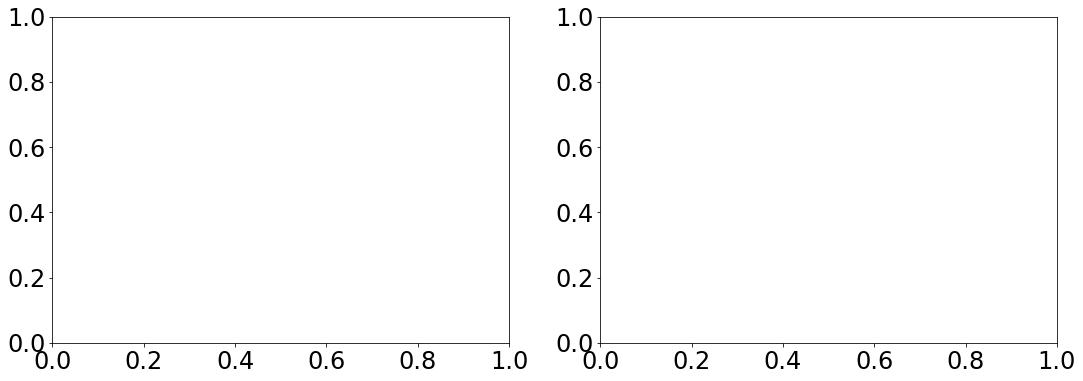

In [68]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_imag_resp_list = []
    std_imag_resp_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        imag_resp_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n = com_arr.shape[-1]
            n_valid = int(n/2)
            time_arr = h5_data['time'][:n_valid]

            ps = power_spec(com_arr)
            power_spec_list += [ps[:n_valid]]
            freq = torch.fft.fftfreq(n_valid*2, time_arr[2]-time_arr[1])
            n_freq = int(freq.size(0)/2)
            print(n_freq == n_valid)
            imag_resp_list[-1]*=freq[:n_freq]
            _ = axarr1[0].plot(freqs[:n_freq], imag_resp_list[-1][:n_freq].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in imag_resp_list])
        imag_resp_mat = torch.stack([avg[:min_length] for avg in imag_resp_list])
        
        avg_imag_resp_list += [imag_resp_mat.mean(axis=0)]
        std_imag_resp_list += [imag_resp_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        _ = axarr1[1].plot(freqs, (avg_power_spec_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Imaginary response function\n' + r"$\alpha'' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

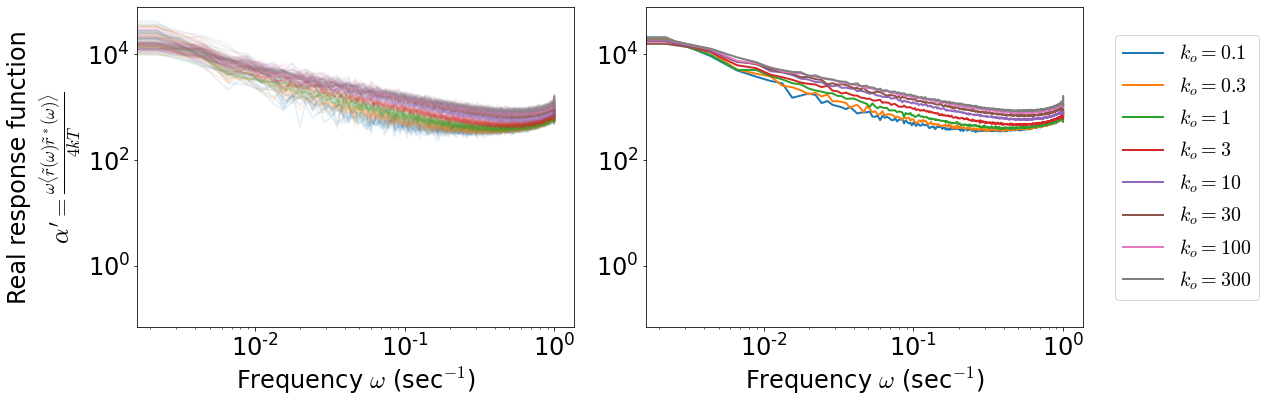

In [ ]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_real_resp_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        im_resp_list = []
        real_resp_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp_list += [freqs * power_spec_list[-1]]
            real_resp_list += [(2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp_list[-1].cpu().numpy())
                )
            )]

            _ = axarr1[0].plot(freqs, real_resp_list[-1], color=colors[i], alpha=.1)
            _ = real_resp_list[-1].to(device)

        min_length = min([len(avg) for avg in real_resp_list])
        real_resp_mat = torch.stack([avg[:min_length] for avg in real_resp_list])
        
        avg_real_resp_list += [real_resp_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_real_resp_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Real response function\n' + r"$\alpha' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

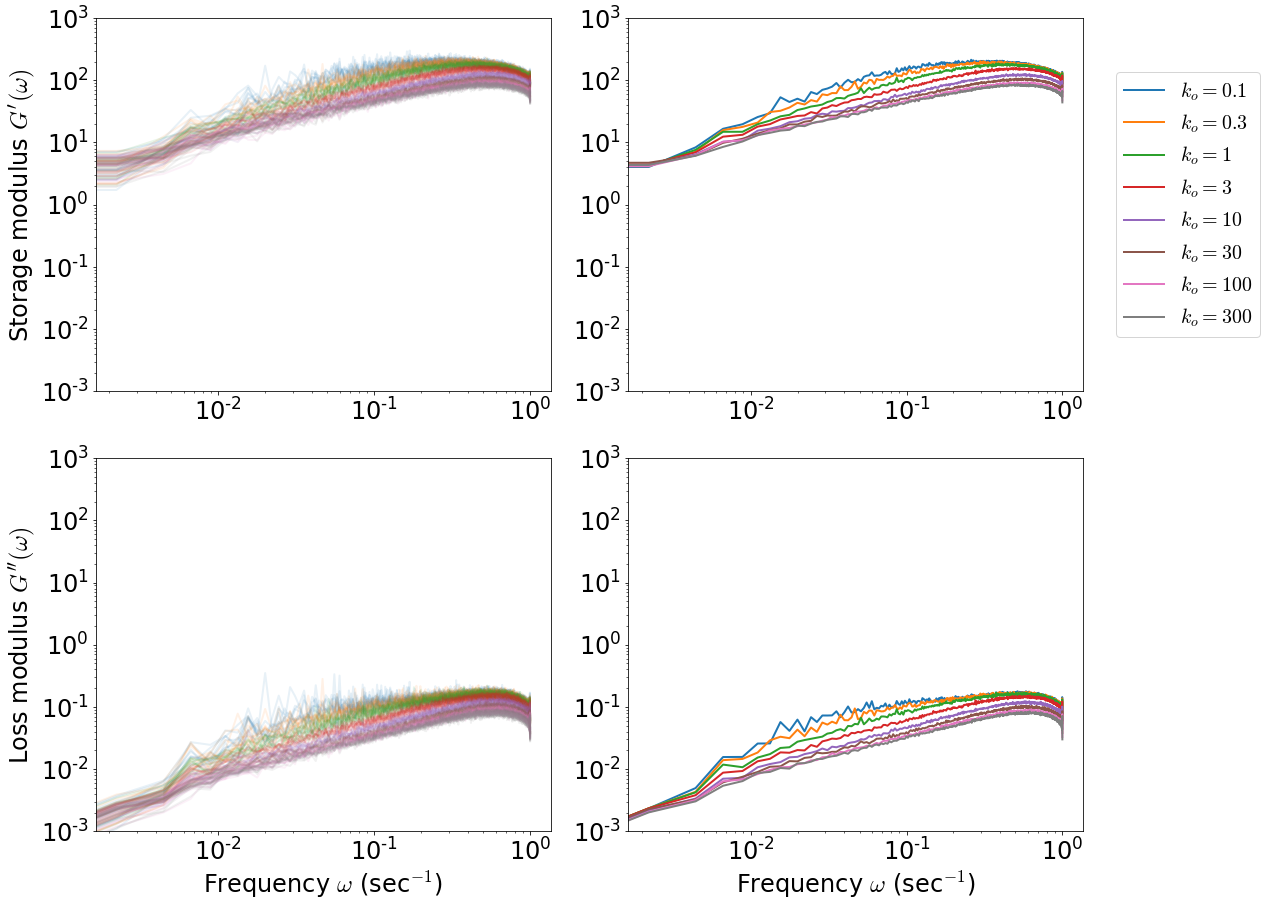

In [75]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

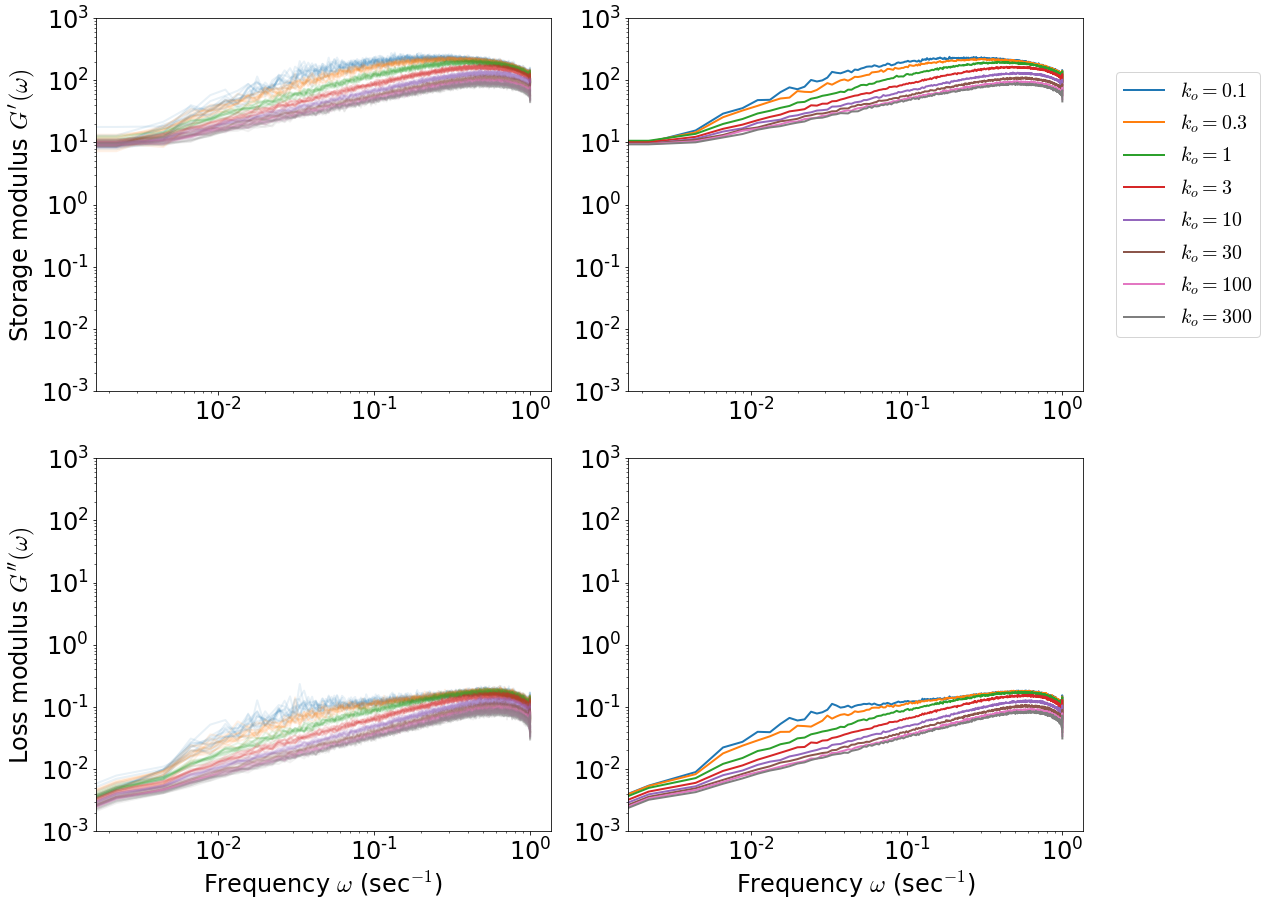

In [78]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            com_arr -= com_arr.mean(axis=0) 
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()